In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import os
import math
from multiprocessing import Pool
from tqdm import tqdm
from scipy import stats
## init
mySpecie='Homo_sapiens'
#prealigned_dir='/cellar/users/btsui/all_seq_snp/Homo_sapiens_all_merged_snp.TCGA.prealigned.pickle'
targetted_align_dir='/cellar/users/btsui/all_seq_snp/Homo_sapiens_all_merged_snp.TCGA.pickle'
manifest_dir='/cellar/users/btsui/Project/METAMAP/notebook/RapMapTest/XGS_WGS/./tcga_lgg_wgs_bams.df.wxs_rnaseq.pickle'

targetted_df=pd.read_pickle(targetted_align_dir).loc["TCGA"]

In [3]:
all_UUIDs=targetted_df.index.get_level_values('Run_digits').unique()

In [4]:
#883, 1427
print ('n UUID:',len(all_UUIDs))

n UUID: 1570


### annotate metadata

In [5]:
manifest_df=pd.read_pickle(manifest_dir)

manifest_df['processed']=manifest_df.file_id.isin(all_UUIDs)

uuid_barcode_mapDf=pd.read_csv('/cellar/users/andreabc/GDC_barcodes/uuid_barcode_map.txt',sep='\t').set_index('file_id')

manifest_df['sample_barcode']=uuid_barcode_mapDf.loc[manifest_df.file_id]['sample_barcode'].values

m_data_category=manifest_df.data_category=='Raw Sequencing Data'
m_experimental_strategy=manifest_df['experimental_strategy'].isin(['RNA-Seq','WXS'])

manifest_df_sub=manifest_df[manifest_df['processed']&m_data_category&m_experimental_strategy]

tmpVC=manifest_df_sub['sample_barcode'].value_counts()

#identify data with both RNAseq and WXS
with_both=tmpVC.index[tmpVC==2]

manifest_df_w_RNA_WXS=manifest_df_sub[manifest_df_sub.sample_barcode.isin(with_both)]


### load in dbSNP vcf

In [7]:
inVcfDir='/data/cellardata/users/btsui/dbsnp/Homo_sapiens/All_20170710.f1_byte2_not_00.vcf.gz' 
vcfDf=pd.read_csv(inVcfDir,sep='\t',header=None)
vcfDf.columns=['Chr','Pos','RsId','RefBase','AltBase','','','Annot']
vcfDf['Chr']=vcfDf['Chr'].astype(np.str)

/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
refI=vcfDf.drop_duplicates(['Chr','Pos','RefBase']).set_index(['Chr','Pos','RefBase']).index

In [22]:
"""for _,vcfDfRowS in vcfDf.iterrows():
    query_chromosome,qeury_corrdinate=vcfDfRowS['Chr'],vcfDfRowS['Pos']
    selectedBase=vcfDfRowS['AltBase']
    break"""

#varscanVcfMerged=pd.read_pickle('/cellar/users/btsui/Project/METAMAP/notebook/RapMapTest/XGS_WGS/Data/TCGA_VCF.varscan_dr.pickle')

In [44]:
vcfDf[vcfDf.Pos==142877758	]

Chr        Pos        RsId RefBase AltBase        \
184405   8  142877758  rs75717953       T       C  .  .   

                                                    Annot  
184405  RS=75717953;RSPOS=142877758;dbSNPBuildID=131;S...

In [24]:
#topTcgaVcfDf=varscanVcfMerged['one_vcf_df'].groupby(
#    ['CHROM','POS','ALT']).size().sort_values(ascending=False).reset_index(name='Count')#.iloc[:100]

In [25]:
#topTcgaVcfDf.iloc[:100]

In [26]:
#371/524.0

In [27]:
#topTcgaVcfDf['Count']

In [9]:
#topTcgaVcfDf['CHROM']=topTcgaVcfDf['CHROM'].str.replace('chr','')

In [10]:
#tmpDf=topTcgaVcfDf.set_index(['CHROM','POS'],drop=False)

In [11]:
#targetted_multI=vcfDf.set_index(['Chr','Pos']).index

In [12]:
#%time existingVC=targetted_df.groupby(['Chr','Pos']).size()

In [13]:
#topTcgaVcfDf_inTargeted=tmpDf[tmpDf.index.isin(targetted_multI)]

In [15]:
manifest_df_w_RNA_WXS.head()

access annotations  \
546   controlled         NaN   
1019  controlled         NaN   
860   controlled         NaN   
791   controlled         NaN   
1285  controlled         NaN   

                                                  cases        data_category  \
546   [{'project': {'project_id': 'TCGA-LGG'}, 'case...  Raw Sequencing Data   
1019  [{'project': {'project_id': 'TCGA-LGG'}, 'case...  Raw Sequencing Data   
860   [{'project': {'project_id': 'TCGA-LGG'}, 'case...  Raw Sequencing Data   
791   [{'project': {'project_id': 'TCGA-LGG'}, 'case...  Raw Sequencing Data   
1285  [{'project': {'project_id': 'TCGA-LGG'}, 'case...  Raw Sequencing Data   

     data_format      data_type experimental_strategy  \
546          BAM  Aligned Reads               RNA-Seq   
1019         BAM  Aligned Reads               RNA-Seq   
860          BAM  Aligned Reads               RNA-Seq   
791          BAM  Aligned Reads               RNA-Seq   
1285         BAM  Aligned Reads               RNA-Seq   

                                   file_id  \
546   1985b367-00c4-4c25-b049-5858e937cc6d   
1019  a7aff6a7-cea4-42e9-8d56-b211843a0302   
860   4038984b-21d1-45d3-a5bb-208f9e71aa78   
791   7b17a5ef-c778-4753-8c30-427af9171f7a   
1285  93e20db7-4892-4ef8-9331-ecd665e4cb91   

                                              file_name   file_size  platform  \
546   948a7b5a-de83-41db-85f1-93a1a9b109ba_gdc_realn...  3293981085  Illumina   
1019  8e4c32f5-1ed2-453b-b029-db7836249d3b_gdc_realn...  4070637137  Illumina   
860   b52aeb27-8d06-4a1c-b322-ee947261e95c_gdc_realn...  4195199173  Illumina   
791   a9bfcb6f-ce2b-47e2-a2e2-dd777b6d1344_gdc_realn...  4436516715  Illumina   
1285  33262d51-82cb-4fe6-89d1-b7e1c4673896_gdc_realn...  4501820893  Illumina   

      processed    sample_barcode  
546        True  TCGA-HT-A4DV-01A  
1019       True  TCGA-HT-A4DS-01A  
860        True  TCGA-FG-A4MW-01A  
791        True  TCGA-DB-A4XC-01A  
1285       True  TCGA-FG-A4MX-01A

Index(['TCGA-P5-A5EV-01A', 'TCGA-TQ-A7RI-01A', 'TCGA-HT-7478-01A',
       'TCGA-QH-A6X8-01A', 'TCGA-HT-7472-01A', 'TCGA-HW-7495-01A',
       'TCGA-DU-7007-01A', 'TCGA-QH-A6CU-01A', 'TCGA-DB-A64R-01A',
       'TCGA-DU-A6S2-01A',
       ...
       'TCGA-QH-A65Z-01A', 'TCGA-RY-A845-01A', 'TCGA-S9-A6U9-01A',
       'TCGA-DH-A7UV-01A', 'TCGA-DU-6402-01A', 'TCGA-DU-6404-01A',
       'TCGA-WH-A86K-01A', 'TCGA-DU-A5TP-01A', 'TCGA-HT-A61B-01A',
       'TCGA-HT-7677-01A'],
      dtype='object', length=524)

In [21]:
querySample='TCGA-HT-A4DV-01A'
statDict={}
for querySample in tqdm(with_both):
    manifest_dmanifest_g=manifest_df_w_RNA_WXS.groupby(['sample_barcode','experimental_strategy'])#['file_id']

    rnaseqUUID=manifest_dmanifest_g.get_group((querySample,'RNA-Seq'))['file_id'].iloc[0]
    wxsUUID=manifest_dmanifest_g.get_group((querySample,'WXS'))['file_id'].iloc[0]

    wxsTargettedDf=targetted_df.loc[wxsUUID].reset_index().set_index(['Chr','Pos'])

    wxsChrPosCountS=wxsTargettedDf.groupby(['Chr','Pos']).size()
    ### take only sites with one allele detected
    homozygous_pos=wxsChrPosCountS[wxsChrPosCountS==1].index
    m_homozygous=wxsTargettedDf.index.isin(homozygous_pos)
    wxsTargettedDf_homo=wxsTargettedDf[m_homozygous]
    wxsTargettedDf_homo=wxsTargettedDf_homo.reset_index().set_index(['Chr','Pos','base'])

    wxsTargettedDf_homo['is_ref_base']=wxsTargettedDf_homo.index.isin(refI)

    (~wxsTargettedDf_homo['is_ref_base']).mean()
    ### ignore the references
    homoGermlineVariantDf=wxsTargettedDf_homo[(~wxsTargettedDf_homo['is_ref_base'])&(wxsTargettedDf_homo['ReadDepth']>=2)&(wxsTargettedDf_homo['AverageBaseQuality']>=30)]
    
    ## check against RNAseq for the variants
    #For homozygous germ line variants, only the reference allele are supposed to be detected

    rnaTagettedDf=targetted_df.loc[rnaseqUUID]
    rnaTagettedDf=rnaTagettedDf[rnaTagettedDf['AverageBaseQuality']>=30]

    rnaseqSiteI=rnaTagettedDf.reset_index().set_index(['Chr','Pos']).index
    wxsHomoSiteI=homoGermlineVariantDf.reset_index().set_index(['Chr','Pos']).index

    interRd=np.intersect1d(wxsHomoSiteI[homoGermlineVariantDf['ReadDepth']>=10],rnaseqSiteI[rnaTagettedDf['ReadDepth']>=10])
    
    nsitesWithReads=len(interRd)
    #print (nsitesWithReads)

    homoGermlineVariantDf.head()

    tmpDf=rnaTagettedDf.unstack()['ReadDepth']

    rnaTagettedFractS=(tmpDf.T/tmpDf.sum(axis=1)).T.stack().to_frame('AllelicFract')

    #inter

    wgxGermlineVarM=rnaTagettedFractS.reset_index().set_index(['Chr','Pos','base']).index.isin(homoGermlineVariantDf.index)
    germLineDf=rnaTagettedFractS[wgxGermlineVarM]
    statDict[querySample]={'percentage_germline_var_with_1_AF':(germLineDf['AllelicFract']==1.0).mean(),
                          'nsites_overlap':nsitesWithReads,
                          'is_alt':(~wxsTargettedDf_homo['is_ref_base']).mean()}

 23%|██▎       | 119/524 [10:04<34:18,  5.08s/it]

KeyboardInterrupt: 

In [24]:
statDf=pd.DataFrame(statDict).T

In [32]:
import seaborn as sns

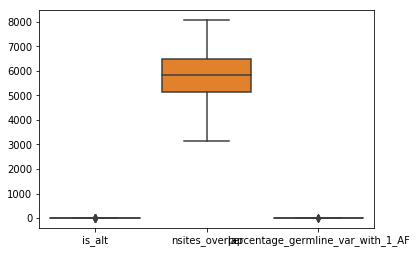

In [33]:
sns.boxplot(data=statDf)

/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'% of RNAseq samples')

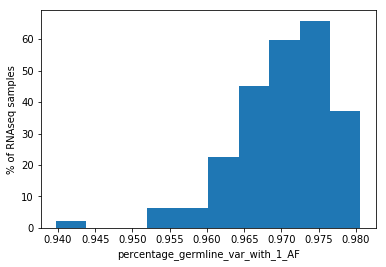

In [40]:
ax=statDf['percentage_germline_var_with_1_AF'].hist(normed=True)
ax.grid(False)
ax.set_xlabel('percentage_germline_var_with_1_AF')
ax.set_ylabel('% of RNAseq samples')

In [31]:
statDf.quantile(axis=0,q=0.025)

is_alt                                  0.106553
nsites_overlap                       3515.250000
percentage_germline_var_with_1_AF       0.955057
Name: 0.025, dtype: float64

In [26]:
statDf.median(axis=0)

is_alt                                  0.112343
nsites_overlap                       5827.000000
percentage_germline_var_with_1_AF       0.971341
dtype: float64

In [353]:
(germLineDf['AllelicFract']==1.0).mean()

0.987914744012305

In [354]:
rnaTargettedReI=rnaTagettedDf[rnaseqSiteI.isin(interRd)].reset_index().set_index(['Chr','Pos','base'])#[interRd]#

In [314]:
rnaTargettedReI['in_homo']=rnaTargettedReI.index.isin(homoGermlineVariantDf.index)

In [315]:
rnaTargettedReI.in_homo.mean()

0.9769743920809124

In [312]:
rnaTargettedReI

ReadDepth  in_homo
Chr Pos       base                    
1   1013541   C      1.000000     True
    1046551   G      1.000000     True
    1049927   G      1.000000     True
    1338000   C      1.000000     True
    1338032   G      1.000000     True
    1338044   G      1.000000     True
    1338086   A      1.000000     True
    1338092   A      1.000000     True
    1338096   C      1.000000     True
    1338098   G      1.000000     True
    1338107   C      1.000000     True
    1398672   C      1.000000     True
    2306122   G      1.000000     True
    2406580   C      1.000000     True
    2408713   C      1.000000     True
    2408714   A      1.000000     True
    2408760   G      1.000000     True
    10375266  A      1.000000     True
    11792316  A      1.000000     True
    11796340  C      1.000000     True
    11846007  C      1.000000     True
    11950377  C      1.000000     True
    11950455  C      1.000000     True
    11998841  T      1.000000     True
    12022869  G      1.000000     True
    15933236  C      1.000000     True
    16986614  A      1.000000     True
    16986848  A      1.000000     True
    16986885  G      1.000000     True
    16987159  C      0.014388    False
...                       ...      ...
X   154357466 G      1.000000     True
    154358335 A      1.000000     True
    154359271 G      1.000000     True
    154359619 T      1.000000     True
    154359789 A      1.000000     True
    154360265 T      1.000000     True
    154364108 T      1.000000     True
    154379719 A      1.000000     True
    154380001 T      1.000000     True
    154380246 A      1.000000     True
    154380976 T      1.000000     True
    154414148 A      1.000000     True
    154420665 C      1.000000     True
    154420704 C      0.017241    False
              T      0.982759     True
    154442419 C      0.002853    False
              T      0.997147     True
    154532439 G      1.000000     True
    154533012 C      1.000000     True
    154546045 C      1.000000     True
    154556194 C      0.983051     True
              T      0.016949    False
    154556237 G      1.000000     True
    154560549 T      1.000000     True
    154765467 T      1.000000     True
    154765524 G      1.000000     True
    154765948 T      1.000000     True
    155090807 C      1.000000     True
    155260815 T      1.000000     True
    155506930 G      1.000000     True

[4647 rows x 2 columns]

In [153]:
rnaReadDepthDf=rnaTagettedDf.unstack()['ReadDepth'].fillna(0)

In [154]:
rnaReadDepthFracDf=(rnaReadDepthDf.T/rnaReadDepthDf.sum(axis=1)).T

In [155]:
rnaSeqS=rnaReadDepthFracDf.stack()

In [239]:
#rnaReadDepthDf.head()

In [235]:
#rnaTagettedDf

In [ ]:
"""
the germline variants are recoved in  
58% of the homoGermline varianst can be recoved in RNAseq
"""

features            ReadDepth  AverageBaseQuality  is_ref_base
Chr Pos       base                                            
1   1013541   C            34                  30        False
    1041950   C            38                  29        False
    1042190   A            18                  31        False
    1043223   C            10                  31        False
    1045707   G            43                  27        False
    1046551   G            33                  28        False
    1047561   C            62                  31        False
    1049927   G            54                  31        False
    1051820   T            28                  32        False
    1086035   G            27                  31        False
    1232684   G            29                  32        False
    1338000   C            26                  32        False
    1338032   G            29                  31        False
    1338044   G            31                  31        False
    1338086   A            18                  29        False
    1338092   A            16                  31        False
    1338096   C            16                  30        False
    1338098   G            17                  30        False
    1338107   C            16                  25        False
    1398672   C            57                  32        False
    1955672   G            67                  32        False
    2024923   A            33                  33        False
    2229045   G            23                  27        False
    2306122   G            14                  32        False
    2406580   C            44                  32        False
    2408713   C            19                  32        False
    2408714   A            21                  32        False
    2408760   G            46                  34        False
    3402939   T            73                  29        False
    3403006   G            25                  31        False
...                       ...                 ...          ...
X   154966119 T            60                  31        False
    154966498 G            37                  34        False
    154966616 C            60                  33        False
    154966617 T            58                  33        False
    154969396 G            82                  34        False
    154969432 G           116                  29        False
    154984784 T            89                  31        False
    154996995 T           143                  31        False
    154999531 T            98                  31        False
    154999543 C           107                  33        False
    155090807 C            13                  32        False
    155260815 T           141                  31        False
    155506930 G            75                  34        False
Y   5057021   G            48                  33        False
    5207530   G            44                  33        False
    5207641   C           104                  32        False
    5207717   C            45                  32        False
    10175852  C            20                  31        False
    16618833  C            57                  29        False
    16618838  C            56                  34        False
    26329144  A            19                  31        False
    26332935  C           118                  32        False
    26333008  A            53                  31        False
    26333079  G            20                  33        False
    26333764  G            34                  34        False
    26337383  A            34                  31        False
    26401079  A            12                  32        False
    26420452  C            25                  33        False
    26420477  G            29                  27        False
    26557077  T            88                  33        False

[15630 rows x 3 columns]

In [193]:
#rnaseqSiteI.isin(wxsHomoSiteI).mean()

0.06863206314358894

In [229]:
interI=np.intersect1d(homoGermlineVariantDf.index ,(rnaSeqS.index))

In [230]:
homoGermlineVariantDf.index.isin(interI).mean()

0.5880358285348688

In [232]:
rnaSeqS

Chr  Pos        base
1    1013541    C       1.000000
     1042190    A       1.000000
     1046551    G       1.000000
     1049927    G       0.988764
     1051820    T       1.000000
     1338000    C       1.000000
     1338032    G       1.000000
     1338044    G       1.000000
     1338086    A       1.000000
     1338092    A       1.000000
     1338096    C       1.000000
     1338098    G       1.000000
     1338107    C       1.000000
     1398672    C       1.000000
     2229045    G       1.000000
     2306122    G       1.000000
     2406580    C       1.000000
     2408713    C       1.000000
     2408714    A       1.000000
     2408760    G       1.000000
     3411655    C       1.000000
     3478076    G       1.000000
     3478110    C       1.000000
     5877256    C       1.000000
     5877331    T       1.000000
     7640514    T       1.000000
     7663384    C       1.000000
     7663428    C       1.000000
     7809988    C       1.000000
     7827433    C     

In [207]:
m=rnaSeqS.index.isin(homoGermlineVariantDf.index)
allelicFractionInGermlineS=rnaSeqS[m]

In [220]:
m.mean()

0.017158015785897235

In [216]:
len(allelicFractionInGermlineS)

9191

In [210]:
len(allelicFractionInGermlineS)

9191

In [213]:
#allelicFractionInGermlineS[allelicFractionInGermlineS==0]

/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'% of germline variants')

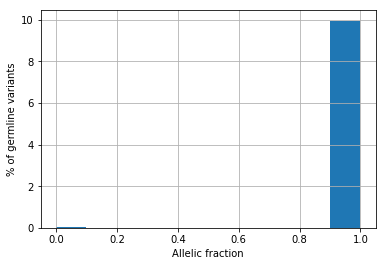

In [212]:
ax=allelicFractionInGermlineS[allelicFractionInGermlineS>=0].hist(bins=10,normed=True)
ax.set_xlabel('Allelic fraction')
ax.set_ylabel('% of germline variants')


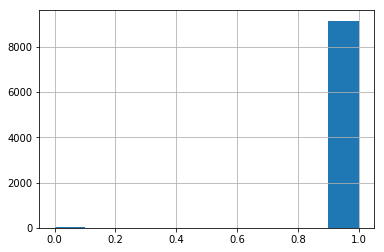

In [158]:

rnaSeqS[rnaSeqS.index.isin(homoGermlineVariantDf.index)].hist()

In [159]:
germlineVariantDf.index.isin(rnaTagettedDf.index).mean()

0.5867562380038388

# scratch

In [33]:
#topTcgaVcfDf_inTargeted.head()

In [34]:
threshold=2

In [ ]:
#### extract all the germ line variants, 

In [ ]:
#threshold=2

#selectedBase='T'
#query_chromosome, qeury_corrdinate='2',208248388
failedS_L=[]
roc_auc_l=[]
m_chr=targetted_df.index.get_level_values('Chr')==query_chromosome
Pos_array=targetted_df.index.get_level_values('Pos')
successCount=0
for vcfIndex,vcfDfRowS in topTcgaVcfDf_inTargeted.iterrows():
    try:
        query_chromosome,qeury_corrdinate=vcfDfRowS['CHROM'].replace('chr',''),vcfDfRowS['POS']
        selectedBase=vcfDfRowS['ALT']

        window_size=0
        
        m_pos=(Pos_array>=(qeury_corrdinate-window_size))&(Pos_array<=(qeury_corrdinate+window_size))
        if m_pos.sum()<10:
            print ('failed')
            continue
        m_qual=targetted_df['AverageBaseQuality']>=30
        #if m_pos.sum()>=0:
        targetted_df_sub=targetted_df[m_pos&m_qual]

        index_metaDf=targetted_df_sub.index.to_frame()

        index_metaDf['sample_barcode']=manifest_df_w_RNA_WXS.set_index('file_id').loc[index_metaDf['Run_digits']]['sample_barcode'].values

        multI=index_metaDf.set_index(['sample_barcode','Run_digits','Chr','Pos','base']).index
        targetted_df_sub.index=multI


        rnaseq_uuids=manifest_df_w_RNA_WXS[manifest_df_w_RNA_WXS['experimental_strategy']=='RNA-Seq']['file_id'].unique()
        m_uuid=targetted_df_sub.index.get_level_values('Run_digits').isin(rnaseq_uuids)
        rnaseq_df=targetted_df_sub[m_uuid]

        groupings_L=['sample_barcode','Chr','Pos','base']

        rnaseq_df=rnaseq_df.groupby(groupings_L).first()

        wxs_uuids=manifest_df_w_RNA_WXS[manifest_df_w_RNA_WXS['experimental_strategy']=='WXS']['file_id'].unique()
        m_uuid=targetted_df_sub.index.get_level_values('Run_digits').isin(wxs_uuids)
        wxs_df=targetted_df_sub[m_uuid]

        wxs_df=wxs_df.groupby(groupings_L).first()

        mergedDf=pd.concat([ rnaseq_df,wxs_df],axis=1,keys=['rna-seq','wxs'])

        mergedDf['wxs']['ReadDepth']=mergedDf['wxs']['ReadDepth'].fillna(0)

        #mergedDf

        #for the whole 

        from sklearn import metrics

        #### get the homozygous

        wxsWithDataDf=mergedDf#[mergedDf['wxs']['ReadDepth']>=threshold]

        sampleRdS=wxsWithDataDf['wxs'].groupby('sample_barcode')['ReadDepth'].sum()
        sampleRdS_rnaseq=wxsWithDataDf['rna-seq'].groupby('sample_barcode')['ReadDepth'].sum()
        
        xwsSamplesWithCoverage=sampleRdS.index[sampleRdS>=threshold]

        m_base=wxsWithDataDf.index.get_level_values('base')==selectedBase

        m_wxs_coverage=wxsWithDataDf.index.get_level_values('sample_barcode').isin(xwsSamplesWithCoverage)

        m_valid_all=mergedDf.notnull().all(axis=1)

        wxsWithDataDf_base=wxsWithDataDf[m_base&m_wxs_coverage]
        wxsWithDataDf_base['rna-seq']=wxsWithDataDf_base['rna-seq'].fillna(0)
        y_true=wxsWithDataDf_base['wxs']['ReadDepth']>=threshold
        
        precision,recall,_=metrics.precision_recall_curve(y_true,
                                       wxsWithDataDf_base['rna-seq']['ReadDepth'].fillna(0))
        roc_auc=metrics.roc_auc_score(y_true,
                                       wxsWithDataDf_base['rna-seq']['ReadDepth'].fillna(0))
        auprc=metrics.auc(recall,precision)
        #print (auprc,wxsWithDataDf_base['rna-seq']['ReadDepth'].fillna(0).mean())
        myResultL=[{'auprc':auprc,'vcfIndex':vcfIndex,"rocauc":roc_auc,
                             'rnaseq_rd':sampleRdS_rnaseq.mean(),
                            'rnaseq_n':((sampleRdS_rnaseq>=10).sum())}]

        roc_auc_l+= myResultL  
        print (myResultL)
        successCount+=1
        print (successCount)
    except ValueError:#ValueError
        failedS_L.append(vcfDfRowS)
        print ('failed')
#group=wxsWithDataDf.groupby('base')

#for base, df in group:
#    break

/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9982105610204264, 'vcfIndex': ('2', 208248388), 'rocauc': 0.9842904603701946, 'rnaseq_rd': 133.82251908396947, 'rnaseq_n': 519}]
1


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.5436157339090322, 'vcfIndex': ('17', 7673803), 'rocauc': 0.9452658347625525, 'rnaseq_rd': 122.07633587786259, 'rnaseq_n': 520}]
2


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed
failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.8651493930905695, 'vcfIndex': ('2', 208248389), 'rocauc': 0.8964102564102564, 'rnaseq_rd': 133.3759541984733, 'rnaseq_n': 519}]
3


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9915456162454604, 'vcfIndex': ('14', 32092134), 'rocauc': 0.5077669902912622, 'rnaseq_rd': 38.31297709923664, 'rnaseq_n': 457}]
4


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9517857142857143, 'vcfIndex': ('2', 208248389), 'rocauc': 0.9577020202020201, 'rnaseq_rd': 133.3759541984733, 'rnaseq_n': 519}]
5


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 1.0, 'vcfIndex': ('15', 90088606), 'rocauc': 1.0, 'rnaseq_rd': 353.8416030534351, 'rnaseq_n': 524}]
6


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.954090909090909, 'vcfIndex': ('17', 7673802), 'rocauc': 0.9488888888888888, 'rnaseq_rd': 121.37284894837477, 'rnaseq_n': 520}]
7


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.7384169884169884, 'vcfIndex': ('8', 142877758), 'rocauc': 0.5, 'rnaseq_rd': 0.0019305019305019305, 'rnaseq_n': 0}]
8


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9895369944981679, 'vcfIndex': ('X', 24789042), 'rocauc': 0.5035885167464115, 'rnaseq_rd': 5.2629482071713145, 'rnaseq_n': 91}]
9


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9999400689281579, 'vcfIndex': ('1', 109690516), 'rocauc': 0.9965412883700822, 'rnaseq_rd': 210.7767175572519, 'rnaseq_n': 513}]
10


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9751543209876543, 'vcfIndex': ('17', 7674872), 'rocauc': 0.9993704752911552, 'rnaseq_rd': 59.13549618320611, 'rnaseq_n': 496}]
11
failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.6849247001118479, 'vcfIndex': ('6', 29944050), 'rocauc': 0.6133071391504189, 'rnaseq_rd': 16.24236641221374, 'rnaseq_n': 286}]
12


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 1.0, 'vcfIndex': ('2', 208248389), 'rocauc': 1.0, 'rnaseq_rd': 133.3759541984733, 'rnaseq_n': 519}]
13


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.998226347522553, 'vcfIndex': ('X', 24788994), 'rocauc': 0.6949317738791423, 'rnaseq_rd': 1291.3740458015268, 'rnaseq_n': 524}]
14


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9941271648588722, 'vcfIndex': ('12', 6018369), 'rocauc': 0.6216216216216216, 'rnaseq_rd': 36.32053742802303, 'rnaseq_n': 431}]
15


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.8950736763236764, 'vcfIndex': ('17', 7674220), 'rocauc': 0.9293664383561644, 'rnaseq_rd': 124.63671128107075, 'rnaseq_n': 520}]
16


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.8500000000000001, 'vcfIndex': ('17', 7675076), 'rocauc': 0.9983935742971888, 'rnaseq_rd': 91.69083969465649, 'rnaseq_n': 510}]
17


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.7798582995951417, 'vcfIndex': ('17', 7675088), 'rocauc': 0.7655677655677655, 'rnaseq_rd': 107.20537428023033, 'rnaseq_n': 509}]
18


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed
failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed
failed
failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9242947346041334, 'vcfIndex': ('12', 6018901), 'rocauc': 0.6154363110008272, 'rnaseq_rd': 79.05152671755725, 'rnaseq_n': 502}]
19


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.967687875497635, 'vcfIndex': ('6', 31271836), 'rocauc': 0.6717948717948719, 'rnaseq_rd': 950.9332061068702, 'rnaseq_n': 524}]
20


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.5249729346906801, 'vcfIndex': ('6', 31356729), 'rocauc': 0.4567348881485007, 'rnaseq_rd': 1370.7922330097088, 'rnaseq_n': 502}]
21
failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9664750957854407, 'vcfIndex': ('7', 117548682), 'rocauc': 0.5, 'rnaseq_rd': 0.39272030651340994, 'rnaseq_n': 1}]
22


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.8435959942590133, 'vcfIndex': ('6', 29943406), 'rocauc': 0.4709963985594237, 'rnaseq_rd': 2902.0687022900765, 'rnaseq_n': 522}]
23


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.6240315082644627, 'vcfIndex': ('6', 29943422), 'rocauc': 0.5176321912862072, 'rnaseq_rd': 2319.403474903475, 'rnaseq_n': 480}]
24


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed
failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed
failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9999999999999998, 'vcfIndex': ('17', 7674221), 'rocauc': 1.0, 'rnaseq_rd': 123.95602294455067, 'rnaseq_n': 520}]
25


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9769153916419274, 'vcfIndex': ('7', 142750675), 'rocauc': 0.49849488260084285, 'rnaseq_rd': 0.3199152542372881, 'rnaseq_n': 3}]
26


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.8815028901734103, 'vcfIndex': ('7', 152238825), 'rocauc': 0.5, 'rnaseq_rd': 9.790076335877863, 'rnaseq_n': 212}]
27


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.7770187787215652, 'vcfIndex': ('17', 7673776), 'rocauc': 0.8756735950731331, 'rnaseq_rd': 121.84351145038168, 'rnaseq_n': 518}]
28


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.5016891891891891, 'vcfIndex': ('9', 128257486), 'rocauc': 0.5, 'rnaseq_rd': 84.02579365079364, 'rnaseq_n': 472}]
29


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9621421257423716, 'vcfIndex': ('7', 142750600), 'rocauc': 0.5010526315789474, 'rnaseq_rd': 0.21595330739299612, 'rnaseq_n': 4}]
30


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.11665167191482981, 'vcfIndex': ('7', 55165350), 'rocauc': 0.6013007054673721, 'rnaseq_rd': 300.21946564885496, 'rnaseq_n': 481}]
31
failed
failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9994991036591797, 'vcfIndex': ('12', 2685853), 'rocauc': 0.7816091954022988, 'rnaseq_rd': 2.092741935483871, 'rnaseq_n': 8}]
32


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9612392525801189, 'vcfIndex': ('4', 144120554), 'rocauc': 0.4796998031496063, 'rnaseq_rd': 0.49236641221374045, 'rnaseq_n': 3}]
33


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.8670477230214318, 'vcfIndex': ('6', 29944118), 'rocauc': 0.6404452281243111, 'rnaseq_rd': 18.980582524271846, 'rnaseq_n': 315}]
34
failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.8319444444444444, 'vcfIndex': ('17', 7674230), 'rocauc': 0.8713235294117647, 'rnaseq_rd': 120.80534351145039, 'rnaseq_n': 519}]
35


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.7957251082251082, 'vcfIndex': ('17', 7674945), 'rocauc': 0.869140625, 'rnaseq_rd': 99.9675572519084, 'rnaseq_n': 513}]
36


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9917339294729354, 'vcfIndex': ('19', 14766987), 'rocauc': 0.5071428571428571, 'rnaseq_rd': 1.315487571701721, 'rnaseq_n': 9}]
37


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.718190399137001, 'vcfIndex': ('7', 55154129), 'rocauc': 0.8454455445544554, 'rnaseq_rd': 182.2767175572519, 'rnaseq_n': 464}]
38


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9565217391304348, 'vcfIndex': ('7', 127611678), 'rocauc': 0.5, 'rnaseq_rd': 0.06451612903225806, 'rnaseq_n': 0}]
39


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9811409712399812, 'vcfIndex': ('1', 235775088), 'rocauc': 0.504950495049505, 'rnaseq_rd': 0.0136986301369863, 'rnaseq_n': 0}]
40


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9224825164827356, 'vcfIndex': ('1', 173828313), 'rocauc': 0.501444707118466, 'rnaseq_rd': 2.292089249492901, 'rnaseq_n': 1}]
41


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9913282738681911, 'vcfIndex': ('2', 166281810), 'rocauc': 0.5231741573033708, 'rnaseq_rd': 1.3317073170731708, 'rnaseq_n': 15}]
42


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed
failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9444444444444444, 'vcfIndex': ('6', 32664778), 'rocauc': 0.5, 'rnaseq_rd': 2.370212765957447, 'rnaseq_n': 8}]
43


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.07298916724566964, 'vcfIndex': ('6', 31270232), 'rocauc': 0.5693114455084359, 'rnaseq_rd': 747.1783567134269, 'rnaseq_n': 401}]
44


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.8904019236433559, 'vcfIndex': ('12', 52897420), 'rocauc': 0.5084404879657105, 'rnaseq_rd': 7.585603112840467, 'rnaseq_n': 71}]
45


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.559769267265185, 'vcfIndex': ('6', 29942825), 'rocauc': 0.797976477463657, 'rnaseq_rd': 2793.31106870229, 'rnaseq_n': 524}]
46


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.46834657753136016, 'vcfIndex': ('6', 29942845), 'rocauc': 0.4998989898989899, 'rnaseq_rd': 2905.9483747609943, 'rnaseq_n': 517}]
47


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9229132597203707, 'vcfIndex': ('6', 29944102), 'rocauc': 0.7980787271567413, 'rnaseq_rd': 21.58206106870229, 'rnaseq_n': 368}]
48


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.8023328381245963, 'vcfIndex': ('6', 29944103), 'rocauc': 0.7773660377358491, 'rnaseq_rd': 21.608778625954198, 'rnaseq_n': 371}]
49


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9422616789380488, 'vcfIndex': ('6', 29944168), 'rocauc': 0.9607098982098983, 'rnaseq_rd': 4361.543893129771, 'rnaseq_n': 524}]
50


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.5614637623652268, 'vcfIndex': ('12', 6018910), 'rocauc': 0.5450518969219758, 'rnaseq_rd': 73.97137404580153, 'rnaseq_n': 500}]
51
failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9961163900517636, 'vcfIndex': ('5', 236441), 'rocauc': 0.5004950495049505, 'rnaseq_rd': 189.5229007633588, 'rnaseq_n': 524}]
52


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.7945205479452055, 'vcfIndex': ('3', 10064460), 'rocauc': 0.5, 'rnaseq_rd': 0.26705653021442494, 'rnaseq_n': 0}]
53


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.5047709923664122, 'vcfIndex': ('3', 179199690), 'rocauc': 0.5, 'rnaseq_rd': 10.774809160305344, 'rnaseq_n': 237}]
54
failed
failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.8408395548245163, 'vcfIndex': ('6', 32661364), 'rocauc': 0.6422820109976433, 'rnaseq_rd': 113.46332046332046, 'rnaseq_n': 358}]
55


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9645215692947171, 'vcfIndex': ('6', 32661416), 'rocauc': 0.6010173721086477, 'rnaseq_rd': 214.6240458015267, 'rnaseq_n': 489}]
56


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.035856045886774615, 'vcfIndex': ('22', 42127537), 'rocauc': 0.4298987568883762, 'rnaseq_rd': 17.948374760994263, 'rnaseq_n': 355}]
57


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9957796476538225, 'vcfIndex': ('6', 32661360), 'rocauc': 0.4311175337186898, 'rnaseq_rd': 97.21606118546845, 'rnaseq_n': 337}]
58
failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9604493382073076, 'vcfIndex': ('6', 29943620), 'rocauc': 0.546979136482179, 'rnaseq_rd': 12.659655831739961, 'rnaseq_n': 238}]
59


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.7750889986870693, 'vcfIndex': ('6', 29944059), 'rocauc': 0.6722366428725935, 'rnaseq_rd': 17.18320610687023, 'rnaseq_n': 315}]
60


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9842224503338726, 'vcfIndex': ('6', 29944067), 'rocauc': 0.8036034099863886, 'rnaseq_rd': 16.535372848948374, 'rnaseq_n': 315}]
61


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


In [193]:
praucDf=pd.DataFrame(roc_auc_l).dropna().head(n=100)#.to_frame('prauc')

In [196]:
praucDf

auprc  rnaseq_n    rnaseq_rd    rocauc        vcfIndex
0   0.998211       519   133.822519  0.984290  (2, 208248388)
1   0.543616       520   122.076336  0.945266   (17, 7673803)
2   0.865149       519   133.375954  0.896410  (2, 208248389)
3   0.991546       457    38.312977  0.507767  (14, 32092134)
4   0.951786       519   133.375954  0.957702  (2, 208248389)
5   1.000000       524   353.841603  1.000000  (15, 90088606)
6   0.954091       520   121.372849  0.948889   (17, 7673802)
7   0.738417         0     0.001931  0.500000  (8, 142877758)
8   0.989537        91     5.262948  0.503589   (X, 24789042)
9   0.999940       513   210.776718  0.996541  (1, 109690516)
10  0.975154       496    59.135496  0.999370   (17, 7674872)
11  0.684925       286    16.242366  0.613307   (6, 29944050)
12  1.000000       519   133.375954  1.000000  (2, 208248389)
13  0.998226       524  1291.374046  0.694932   (X, 24788994)
14  0.994127       431    36.320537  0.621622   (12, 6018369)
15  0.895074       520   124.636711  0.929366   (17, 7674220)
16  0.850000       510    91.690840  0.998394   (17, 7675076)
17  0.779858       509   107.205374  0.765568   (17, 7675088)
18  0.924295       502    79.051527  0.615436   (12, 6018901)
19  0.967688       524   950.933206  0.671795   (6, 31271836)
20  0.524973       502  1370.792233  0.456735   (6, 31356729)
21  0.966475         1     0.392720  0.500000  (7, 117548682)
22  0.843596       522  2902.068702  0.470996   (6, 29943406)
23  0.624032       480  2319.403475  0.517632   (6, 29943422)
24  1.000000       520   123.956023  1.000000   (17, 7674221)
25  0.976915         3     0.319915  0.498495  (7, 142750675)
26  0.881503       212     9.790076  0.500000  (7, 152238825)
27  0.777019       518   121.843511  0.875674   (17, 7673776)
28  0.501689       472    84.025794  0.500000  (9, 128257486)
29  0.962142         4     0.215953  0.501053  (7, 142750600)
..       ...       ...          ...       ...             ...
70  0.002137        16     2.042345  0.495708  (1, 237591774)
71  0.808434       524  3416.650763  0.442027   (6, 29944376)
72  0.232668       524  3618.646947  0.603043   (6, 29944151)
73  0.741291       506   315.198473  0.621487   (6, 32664883)
74  0.026316       436   162.306796  0.784810   (6, 32664926)
75  0.863203       395    31.936902  0.488386   (10, 4999206)
76  0.815908       493   215.211832  0.928361   (6, 32661393)
77  0.380747       480   191.682692  0.596527   (6, 32661384)
78  0.778990        27     2.581081  0.645061   (6, 32661333)
79  0.007407         0     1.307692  0.481203  (12, 57099758)
80  0.641934       524   353.841603  0.795312  (15, 90088606)
81  0.993934       523  1127.133588  0.582806   (16, 2106849)
82  0.995522       517  1391.395753  0.989221   (6, 29942795)
83  0.965023       510  2437.399610  0.856497   (6, 29942858)
84  0.061988       524  2200.085878  0.573877   (6, 29942916)
85  0.756602        29     2.614504  0.669605   (3, 75630855)
86  0.224100        13     1.728489  0.588009   (3, 75630794)
87  0.549532       103     7.149510  0.523889   (3, 49686483)
88  0.683612       519  1443.973282  0.499179   (6, 29943463)
89  0.758810        35     3.059961  0.520303   (6, 29943667)
90  0.858112       523    66.984733  0.899413  (3, 179234284)
91  0.844742       513    88.143130  0.874750   (17, 7674888)
92  1.000000       517   117.526718  1.000000   (17, 7674256)
93  0.493328       512    82.120229  0.692187   (17, 7673704)
94  0.403970        55     3.786275  0.490953  (17, 21416556)
95  0.666459       523   986.114504  0.500538  (8, 100709671)
96  0.951125         0     0.047244  0.509217  (3, 183959847)
97  0.671406       501    94.854127  0.794175  (17, 31350209)
98  0.530668       518   380.994275  0.738304   (5, 68295269)
99  0.870781       495    23.572519  0.462571  (22, 24627926)

[100 rows x 5 columns]

In [194]:
(praucDf['auprc']<0.1).mean()

0.09

In [190]:
(praucDf['auprc']>0.8).mean()

0.73

In [186]:
praucDf.head()

auprc  rnaseq_n   rnaseq_rd        vcfIndex
0  0.998211       519  133.822519  (2, 208248388)
1  0.543616       520  122.076336   (17, 7673803)
2  0.865149       519  133.375954  (2, 208248389)
3  0.991546       448   38.312977  (14, 32092134)
4  0.951786       519  133.375954  (2, 208248389)

In [187]:
import matplotlib.pyplot as plt

Text(0.5,0,'AUPRC')

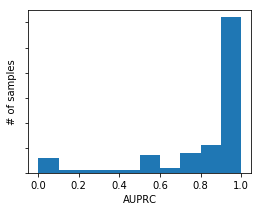

In [188]:
fig,ax=plt.subplots(figsize=(4,3))
praucDf['auprc'].hist(ax=ax)
#ax.set_yticklabels([])
ax.grid(False)
ax.set_yticklabels([])
ax.set_ylabel('# of samples')
ax.set_xlabel('AUPRC')

In [189]:
praucS=pd.Series(roc_auc_l).dropna()
(praucS>0.8).mean()

TypeError: '>' not supported between instances of 'dict' and 'float'

/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


TypeError: '<' not supported between instances of 'dict' and 'float'

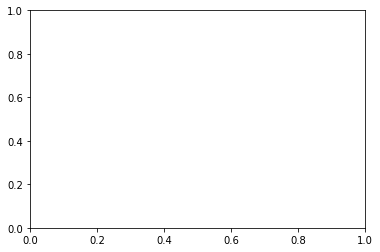

In [182]:
ax=pd.Series(roc_auc_l).hist(normed=True)
ax

In [99]:
wxsWithDataDf_base.head()

Empty DataFrame
Columns: [(rna-seq, ReadDepth), (rna-seq, AverageBaseQuality), (wxs, ReadDepth), (wxs, AverageBaseQuality)]
Index: []

In [20]:
threshold=2

selectedBase='T'
query_chromosome, qeury_corrdinate='2',208248388
m_chr=targetted_df.index.get_level_values('Chr')==query_chromosome
Pos_array=targetted_df.index.get_level_values('Pos')
window_size=0

m_pos=(Pos_array>=(qeury_corrdinate-window_size))&(Pos_array<=(qeury_corrdinate+window_size))
m_qual=targetted_df['AverageBaseQuality']>=30

targetted_df_sub=targetted_df[m_pos&m_qual]

index_metaDf=targetted_df_sub.index.to_frame()

index_metaDf['sample_barcode']=manifest_df_w_RNA_WXS.set_index('file_id').loc[index_metaDf['Run_digits']]['sample_barcode'].values

multI=index_metaDf.set_index(['sample_barcode','Run_digits','Chr','Pos','base']).index
targetted_df_sub.index=multI


rnaseq_uuids=manifest_df_w_RNA_WXS[manifest_df_w_RNA_WXS['experimental_strategy']=='RNA-Seq']['file_id'].unique()
m_uuid=targetted_df_sub.index.get_level_values('Run_digits').isin(rnaseq_uuids)
rnaseq_df=targetted_df_sub[m_uuid]

groupings_L=['sample_barcode','Chr','Pos','base']

rnaseq_df=rnaseq_df.groupby(groupings_L).first()

wxs_uuids=manifest_df_w_RNA_WXS[manifest_df_w_RNA_WXS['experimental_strategy']=='WXS']['file_id'].unique()
m_uuid=targetted_df_sub.index.get_level_values('Run_digits').isin(wxs_uuids)
wxs_df=targetted_df_sub[m_uuid]

wxs_df=wxs_df.groupby(groupings_L).first()

mergedDf=pd.concat([ rnaseq_df,wxs_df],axis=1,keys=['rna-seq','wxs'])

mergedDf['wxs']['ReadDepth']=mergedDf['wxs']['ReadDepth'].fillna(0)

#mergedDf

#for the whole 

from sklearn import metrics

#### get the homozygous

wxsWithDataDf=mergedDf#[mergedDf['wxs']['ReadDepth']>=threshold]

sampleRdS=wxsWithDataDf['wxs'].groupby('sample_barcode')['ReadDepth'].sum()

xwsSamplesWithCoverage=sampleRdS.index[sampleRdS>threshold]

m_base=wxsWithDataDf.index.get_level_values('base')==selectedBase

m_wxs_coverage=wxsWithDataDf.index.get_level_values('sample_barcode').isin(xwsSamplesWithCoverage)

m_valid_all=mergedDf.notnull().all(axis=1)

wxsWithDataDf_base=wxsWithDataDf[m_base&m_wxs_coverage]

wxsWithDataDf_base['rna-seq']=wxsWithDataDf_base['rna-seq'].fillna(0)

#wxsWithDataDf_base['rna-seq']['ReadDepth'].hist()

#wxsWithDataDf_base['wxs']['ReadDepth'].hist()

y_true=wxsWithDataDf_base['wxs']['ReadDepth']>=threshold



precision,recall,_=metrics.precision_recall_curve(y_true,
                               wxsWithDataDf_base['rna-seq']['ReadDepth'].fillna(0))
auprc=metrics.auc(recall,precision)

#group=wxsWithDataDf.groupby('base')

#for base, df in group:
#    break

/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  del sys.path[0]
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [296]:
index_metaDf=targetted_df_sub.index.to_frame()

index_metaDf['sample_barcode']=manifest_df_w_RNA_WXS.set_index('file_id').loc[index_metaDf['Run_digits']]['sample_barcode'].values

multI=index_metaDf.set_index(['sample_barcode','Run_digits','Chr','Pos','base']).index
targetted_df_sub.index=multI

wxs_df=targetted_df_sub[m_uuid]#.loc[wxs_uuid]

/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  This is separate from the ipykernel package so we can avoid doing imports until


In [29]:
%time wxs_df=wxs_df.groupby(groupings_L).first()

CPU times: user 72 ms, sys: 32 ms, total: 104 ms
Wall time: 102 ms


In [30]:
rnaseq_uuids=manifest_df_w_RNA_WXS[manifest_df_w_RNA_WXS['experimental_strategy']=='RNA-Seq']['file_id'].unique()

m_uuid=targetted_df_sub.index.get_level_values('Run_digits').isin(rnaseq_uuids)

rnaseq_df=targetted_df_sub[m_uuid]#.loc[rnaseq_uuid]

In [31]:
%time rnaseq_df=rnaseq_df.groupby(groupings_L).first()

CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 28.5 ms


In [32]:
mergedDf=pd.concat([ rnaseq_df,wxs_df],axis=1,keys=['rna-seq','wxs'])

In [33]:
mergedDf=mergedDf[~mergedDf.isnull().all(axis=1)]

## identify IDH1 mutations

In [34]:
#ref C
IDH1_corrdinate=208248388
mergedDf_subDf=mergedDf[mergedDf.index.get_level_values('Pos')==IDH1_corrdinate]

In [35]:
m_quality=(mergedDf_subDf['wxs']['AverageBaseQuality']>20)
ref_alt='T'
m_alt=(mergedDf_subDf.index.get_level_values('base'))==ref_alt

qualFilteredDf=mergedDf_subDf[m_quality]

In [36]:
unstackDf=qualFilteredDf.unstack()

In [37]:
unstackDf.head()

rna-seq                                      \
features                       ReadDepth                  AverageBaseQuality   
base                                   A      C   G     T                  A   
sample_barcode   Chr Pos                                                       
TCGA-CS-4938-01B 2   208248388       NaN   68.0 NaN  24.0                NaN   
TCGA-CS-4941-01A 2   208248388       NaN  235.0 NaN   NaN                NaN   
TCGA-CS-4942-01A 2   208248388       NaN  140.0 NaN  19.0                NaN   
TCGA-CS-4944-01A 2   208248388       NaN   43.0 NaN  17.0                NaN   
TCGA-CS-5390-01A 2   208248388       NaN   95.0 NaN  32.0                NaN   

                                                     wxs                   \
features                                       ReadDepth                    
base                               C   G     T         A      C   G     T   
sample_barcode   Chr Pos                                                    
TCGA-CS-4938-01B 2   208248388  37.0 NaN  38.0       NaN   87.0 NaN  29.0   
TCGA-CS-4941-01A 2   208248388  37.0 NaN   NaN       NaN  182.0 NaN   NaN   
TCGA-CS-4942-01A 2   208248388  38.0 NaN  38.0       NaN  192.0 NaN  46.0   
TCGA-CS-4944-01A 2   208248388  37.0 NaN  37.0       NaN  149.0 NaN  43.0   
TCGA-CS-5390-01A 2   208248388  37.0 NaN  38.0       NaN  141.0 NaN  51.0   

                                                                   
features                       AverageBaseQuality                  
base                                            A     C   G     T  
sample_barcode   Chr Pos                                           
TCGA-CS-4938-01B 2   208248388                NaN  29.0 NaN  29.0  
TCGA-CS-4941-01A 2   208248388                NaN  27.0 NaN   NaN  
TCGA-CS-4942-01A 2   208248388                NaN  25.0 NaN  28.0  
TCGA-CS-4944-01A 2   208248388                NaN  27.0 NaN  28.0  
TCGA-CS-5390-01A 2   208248388                NaN  26.0 NaN  27.0

In [38]:
from sklearn import metrics

In [39]:
import matplotlib.pyplot as plt

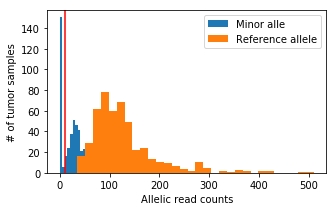

In [45]:

fig,ax=plt.subplots(figsize=(5,3))

unstackDf[('wxs','ReadDepth','T')].fillna(0).hist(bins=30,label='Minor alle',ax=ax)
unstackDf[('wxs','ReadDepth','C')].fillna(0).hist(bins=30,ax=ax,
                                                  label='Reference allele')
ax.axvline(x=10,c='red')
ax.set_ylabel('# of tumor samples')
ax.legend()
ax.set_xlabel('Allelic read counts')
ax.grid(False)


In [48]:
(unstackDf[('wxs','ReadDepth','T')]>0).sum()

351

In [41]:
asdasdas

NameError: name 'asdasdas' is not defined

In [ ]:
y_true=(>10)

In [ ]:
y_true.value_counts()

In [ ]:
print ('ROC AUC',metrics.roc_auc_score(y_true,
                      unstackDf[('rna-seq','ReadDepth','T')].fillna(0)))
precision, recall, thresholds=metrics.precision_recall_curve(y_true,
                      unstackDf[('rna-seq','ReadDepth','T')].fillna(0))
ax=pd.DataFrame({'precision':precision,'recall':recall}).plot(x='recall',y='precision')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
metrics.auc(recall,precision)
ax.set_title('IDH1 C>T mutation using RNAseq')

In [ ]:
import seaborn as sns

In [ ]:
qualFilteredDf[('wxs','ReadDepth')].index.get_level_values('base').value_counts()

In [ ]:
qualFilteredDf[('rna-seq','ReadDepth')].index.get_level_values('base').value_counts()

In [ ]:
qualFilteredDf[('rna-seq','ReadDepth')].index.get_level_values('base').value_counts()

In [ ]:
mergedDf_subDf

In [ ]:

qualFilteredDf['ReadDepth'],qualFilteredDf['wxs']>3

In [ ]:
##c 


In [ ]:
#qualFilteredDf[]

In [ ]:
unstackDf=qualFilteredDf['wxs'].unstack()['ReadDepth']

In [ ]:
#qualFilteredDf['wxs'].unstack()['ReadDepth']

In [ ]:
sns.jointplot(data=qualFilteredDf[qualFilteredDf.index.get_level_values('base')=='T'],x=('rna-seq','ReadDepth'),y=('wxs','ReadDepth'))


In [ ]:
#categorical_crossentropy

In [ ]:
### generate the correlation between the data 